# Forest Cover Type Prediction
*Kevin Zagalo, Ismail Benkirane*

Le but de ce projet est de modifier les données et construire une methode pour classifier des forêts en 7 types, avec des données de 581 012 instances et 54 attributs, sans données manquantes. Les types de forêts sont les suivants :
      - Spruce/Fir
      - Lodgepole Pine
      - Ponderosa Pine
      - Cottonwood/Willow
      - Aspen
      - Douglas-fir
      - Krummholz
dont les attributs sont les suivants :
      - Elevation / quantitative /meters / Elevation in meters 
      - Aspect / quantitative / azimuth / Aspect in degrees azimuth 
      - Slope / quantitative / degrees / Slope in degrees 
      - Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features 
      - Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features 
      - Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway 
      - Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice 
      - Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice 
      - Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice 
      - Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points 
      - Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation 
      - Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation 
      - Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation

## Chargement des données

### Télécharement des données

Les données https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data seront téléchargées à l'adresse *'./covtype/archives/'*

In [23]:
from urllib.request import urlopen
import os.path as osp
import os
import logging
import gzip
logging.getLogger().setLevel('INFO')

### Mémorisation des données dans un DataFrame

In [24]:
import pandas as pd
import numpy as np
import covtype

In [25]:
dict_attributs = {'Elevation':[0],'Aspect':[1],'Slope':[2],
                  'Horizontal_Distance_To_Hydrology':[3],
                  'Vertical_Distance_To_Hydrology':[4],
                  'Horizontal_Distance_To_Roadways':[5],
                  'Hillshade_9am':[6],'Hillshade_Noon':[7],
                  'Hillshade_3pm':[8],
                  'Horizontal_Distance_To_Fire_Points':[9],
                  'Wilderness_Area':[10,11,12,13],
                  'Soil_Type':list(range(14,54)),
                  'Cover_Type':[54]}

forest_cover_types = {1:'Spruce/Fir',2:'Lodgepole Pine',3:'Ponderosa Pine',
                      4:'Cottonwood/Willow',5:'Aspen',6:'Douglas-fir',7:'Krummholz'}

In [26]:
# df_covtype : DataFrame de toutes les données non traitées triées par attribut
df_covtype = pd.read_csv('covtype/archives/covtype.data.gz',
                         header=None,
                         parse_dates=dict_attributs,
                         compression='gzip')

# labels : array des étiquettes des types de forêts
covtypes = list(set(df_covtype.Cover_Type.astype('int')))

Le problème de ce chargement est qu'il stocke les données en type *str*, il nous faut donc convertir le type des données en *int*.

In [27]:
for attribut in dict_attributs:
    if not(attribut in ['Wilderness_Area','Soil_Type']):
        df_covtype[attribut] = df_covtype[attribut].astype('int')

In [28]:
df_covtype.tail()

,Aspect,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways,Cover_Type,Hillshade_3pm,Soil_Type,Elevation,Hillshade_Noon,Hillshade_9am,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,Wilderness_Area,Slope
581007,153,837,108,3,118,0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,2396,237,240,17,85,0 0 1 0,20
581008,152,845,95,3,119,0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,2391,237,240,12,67,0 0 1 0,19
581009,159,854,90,3,130,0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,2386,241,236,7,60,0 0 1 0,17
581010,170,864,90,3,143,0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,2384,245,230,5,60,0 0 1 0,15
581011,165,875,67,3,141,0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,2383,244,231,4,60,0 0 1 0,13


## Analyse préliminaire et pré-traitement des données 

Avant toute modification des données et/ou élaboration de méthodes, nous tenterons de mieux comprendre les données pour eventuellement les modifier, c'est-à-dire :
- exhiber des corrélations
- supprimer des données inutiles
- ajouter des données qui seraient plus pertinentes
- modifier la façon de "qualifier" les données qualitatives

Le fichier *covtype.py* contient la fonction $\verb!scatter!$ qui affiche les nuages de points et les histogrammes de chaque attribut si le paramètre *volume = False*, et si les attributs sont au nombre de 3 et *volume = True*, alors on affiche les données dans un espace en 3-D. 

In [29]:
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

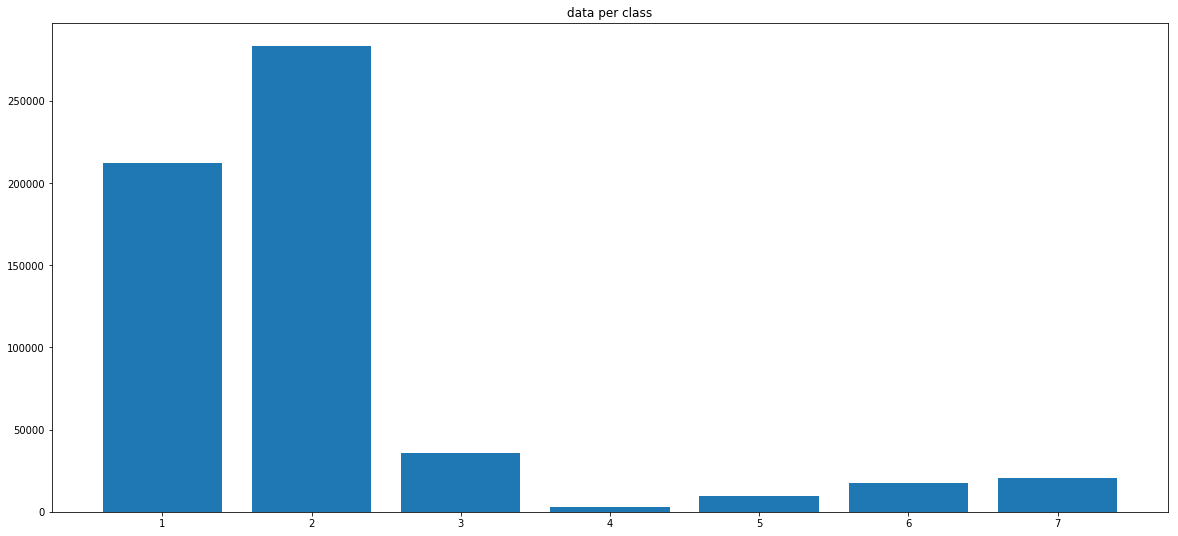

In [30]:
nb_per_covtype = df_covtype.groupby('Cover_Type').size()
plt.bar(covtypes,nb_per_covtype.values)
plt.title('data per class')
plt.show()

Tout d'abord on constate sur la figure précédente que les données sont inégalement réparties selon les classes. Cela peut vouloir dire plusieurs choses : soit nos données sont mal échantillonnées, soit les types 1 et 2 sont effectivement largement plus répandues.	C'est quelque chose dont nous n'avons pas la maitrise, une discussion avec un expert sur le sujet serait préférable. Nous continuerons l'étude sans experts et en supposant que les données sont raisonnablement échantillonnées.
	
La suite consistera globalement à faire la même chose sur le reste des données grâce aux méthodes de la bibliothèque pandas.

### Visualisation des données qualitatives

On préfèrera garder dans le DataFrame **df_covtype** des entiers plutôt que des vecteurs binaires, quitte à les y remettre dans les données de train et de test ensuite. Cela facilitera grandement l'analyse préliminaire. 

In [31]:
wilderness = covtype.convert_to_binary(df_covtype.Wilderness_Area)
soil = covtype.convert_to_binary(df_covtype.Soil_Type)

On utilisera donc **wilderness** et **soil** uniquement pour la partie test des modèles. C'est ce à quoi servent les fonctions $\verb!convert_to_binary!$ et $\verb!convert_to_int!$ du fichier *covtype.py*.  :

- **Wilderness_Areas**
    - 1 : Rawah Wilderness Area
    - 2 : Neota Wilderness Area
    - 3 : Comanche Peak Wilderness Area
    - 4 : Cache la Poudre Wilderness Area


- **Soil_Types**
    - 1 : Cathedral family - Rock outcrop complex, extremely stony.
    - 2 : Vanet - Ratake families complex, very stony.
    - 3 : Haploborolis - Rock outcrop complex, rubbly.
    - 4 : Ratake family - Rock outcrop complex, rubbly.
    - 5 : Vanet family - Rock outcrop complex complex, rubbly.
    - 6 : Vanet - Wetmore families - Rock outcrop complex, stony.
    - 7 : Gothic family.
    - 8 : Supervisor - Limber families complex.
    - 9 : Troutville family, very stony.
    - 10 : Bullwark - Catamount families - Rock outcrop complex, rubbly.
    - 11 : Bullwark - Catamount families - Rock land complex, rubbly.
    - 12 : Legault family - Rock land complex, stony.
    - 13 : Catamount family - Rock land - Bullwark family complex, rubbly.
    - 14 : Pachic Argiborolis - Aquolis complex.
    - 15 : unspecified in the USFS Soil and ELU Survey.
    - 16 : Cryaquolis - Cryoborolis complex.
    - 17 : Gateview family - Cryaquolis complex.
    - 18 : Rogert family, very stony.
    - 19 : Typic Cryaquolis - Borohemists complex.
    - 20 : Typic Cryaquepts - Typic Cryaquolls complex.
    - 21 : Typic Cryaquolls - Leighcan family, till substratum complex.
    - 22 : Leighcan family, till substratum, extremely bouldery.
    - 23 : Leighcan family, till substratum - Typic Cryaquolls complex.
    - 24 : Leighcan family, extremely stony.
    - 25 : Leighcan family, warm, extremely stony.
    - 26 : Granile - Catamount families complex, very stony.
    - 27 : Leighcan family, warm - Rock outcrop complex, extremely stony.
    - 28 : Leighcan family - Rock outcrop complex, extremely stony.
    - 29 : Como - Legault families complex, extremely stony.
    - 30 : Como family - Rock land - Legault family complex, extremely stony.
    - 31 : Leighcan - Catamount families complex, extremely stony.
    - 32 : Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
    - 33 : Leighcan - Catamount families - Rock outcrop complex, extremely stony.
    - 34 : Cryorthents - Rock land complex, extremely stony.
    - 35 : Cryumbrepts - Rock outcrop - Cryaquepts complex.
    - 36 : Bross family - Rock land - Cryumbrepts complex, extremely stony.
    - 37 : Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
    - 38 : Leighcan - Moran families - Cryaquolls complex, extremely stony.
    - 39 : Moran family - Cryorthents - Leighcan family complex, extremely stony.
    - 40 : Moran family - Cryorthents - Rock land complex, extremely stony.

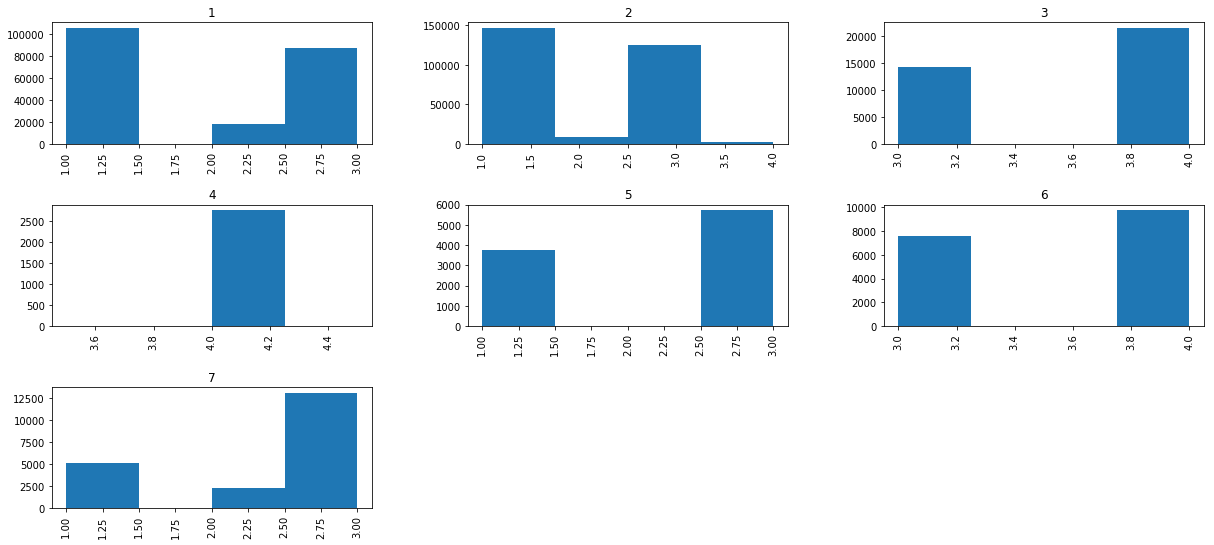

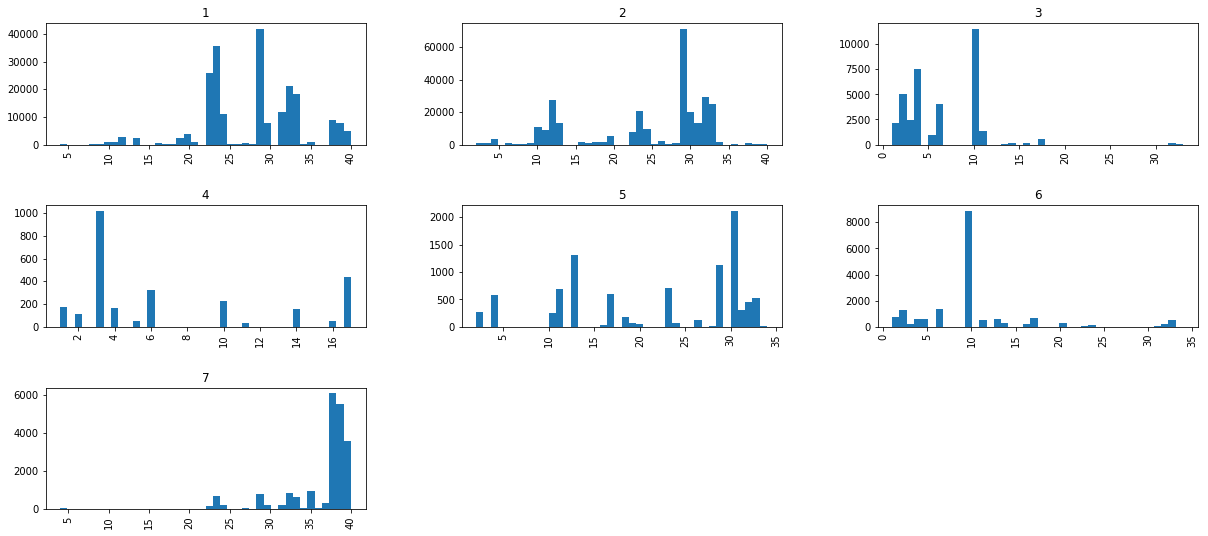

In [32]:
for attribut,vect in ('Wilderness_Area',wilderness),('Soil_Type',soil):
    df_covtype[attribut] = covtype.convert_to_int(vect)
    df_covtype.hist(by='Cover_Type',column=attribut,bins=max(df_covtype[attribut]),grid=False)
    plt.show()

On voit que les distributions des deux données qualitatives sont importantes, nous allons donc les garder, malgré le fait que nous ayons 54 paramètres au lieu de 10.

### Visualisation des données numériques

On regarde d'abord les valeurs moyennes de chaque attribut, par classe, pour observer une première fois les attributs les plus significatifs.

In [33]:
df_covtype.groupby('Cover_Type').mean()

,Aspect,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Roadways,Hillshade_3pm,Soil_Type,Elevation,Hillshade_Noon,Hillshade_9am,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,Wilderness_Area,Slope
Cover_Type,,,,,,,,,,,,
1,156.138227,2009.253517,2614.834517,143.875038,27.749514,3128.644888,223.430211,211.998782,42.156939,270.555245,1.914138,13.127110
2,152.060515,2168.154849,2429.530799,142.983466,24.351732,2920.936061,225.326596,213.844423,45.884219,279.916442,1.946869,13.550499
3,176.372490,910.955949,943.940734,140.367176,6.285618,2394.509845,215.826537,201.918415,62.446915,210.276473,3.600045,20.770208
4,137.139425,859.124135,914.199490,111.392792,7.028031,2223.939934,216.997088,228.345832,41.186749,106.934838,4.000000,18.528941
5,139.283051,1577.719794,1349.765722,121.920889,21.696303,2787.417571,219.035816,223.474876,50.610344,212.354893,2.203413,16.641315
6,180.539068,1055.351471,1037.169805,148.284044,10.174814,2419.181897,209.827662,192.844302,45.437439,159.853458,3.560891,19.048886
7,153.236226,2070.031594,2738.250463,134.932033,36.608191,3361.928669,221.746026,216.967723,69.474305,356.994686,2.390249,14.255924


On commence par trier les données par ordre d'importance :

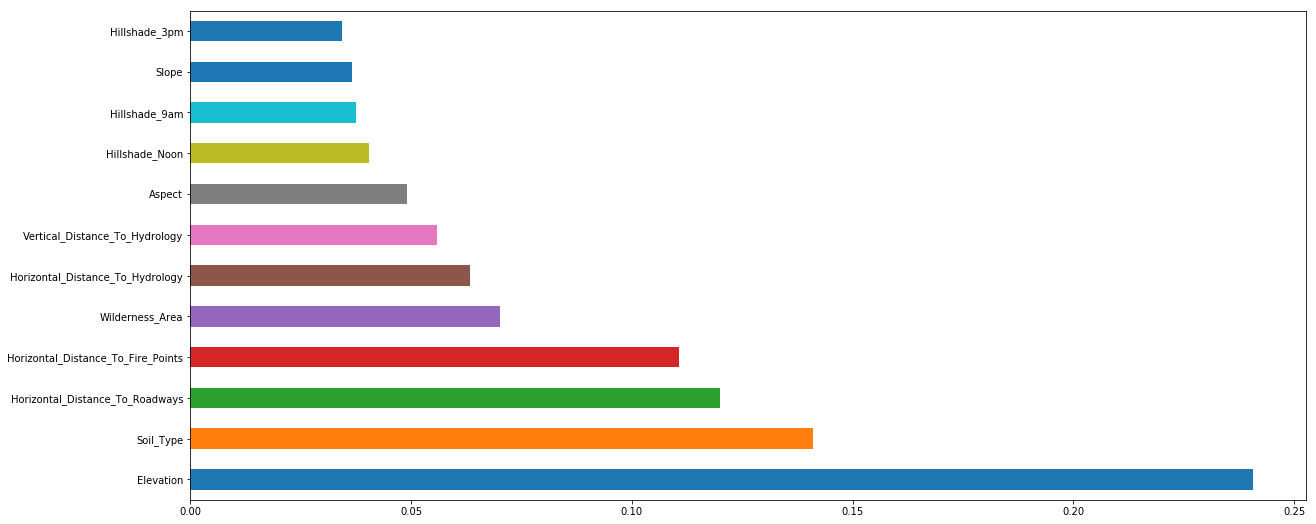

In [34]:
from sklearn.ensemble import ExtraTreesClassifier

data = df_covtype.drop('Cover_Type',axis=1)
target = df_covtype.Cover_Type.values
modele = ExtraTreesClassifier()
modele.fit(data,target)
# print(modele.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
att_importances = pd.Series(modele.feature_importances_, index=data.columns)
att_importances.nlargest(52).plot(kind='barh')
plt.rcParams["figure.figsize"] = [20,9]
plt.show()

#### Regardons en détail les 4 attributs les plus importants

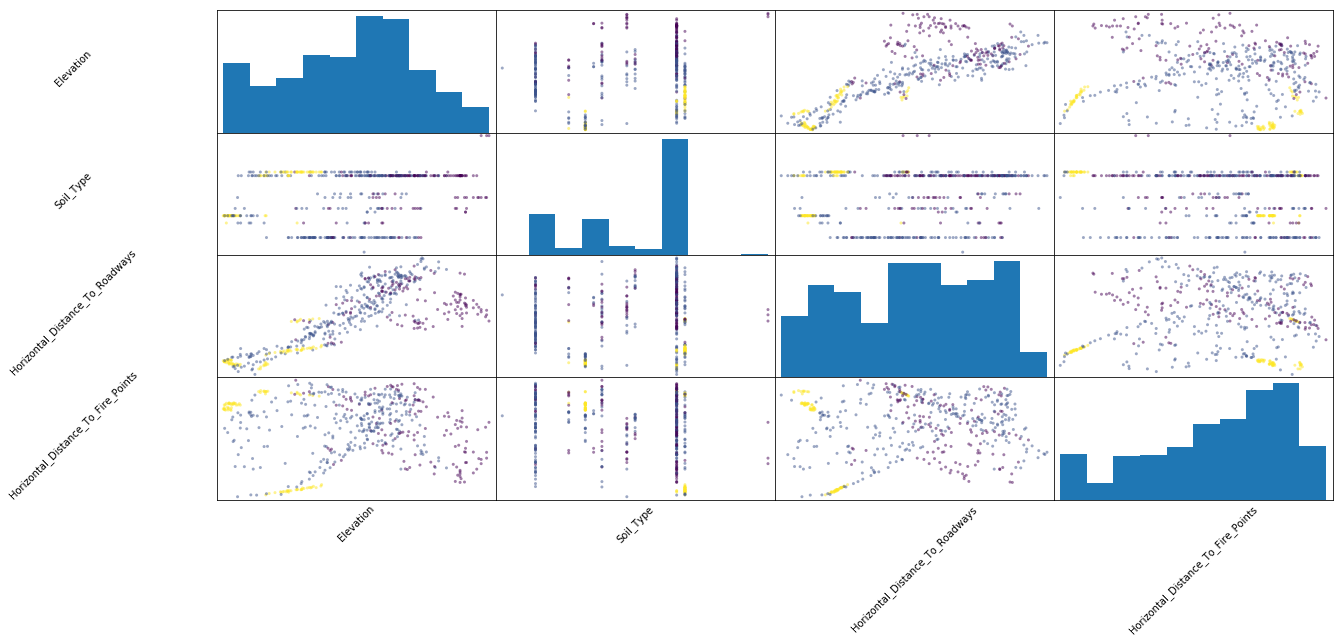

In [35]:
covtype.scatter(df_covtype,['Elevation','Soil_Type','Horizontal_Distance_To_Roadways',
                            'Horizontal_Distance_To_Fire_Points'])

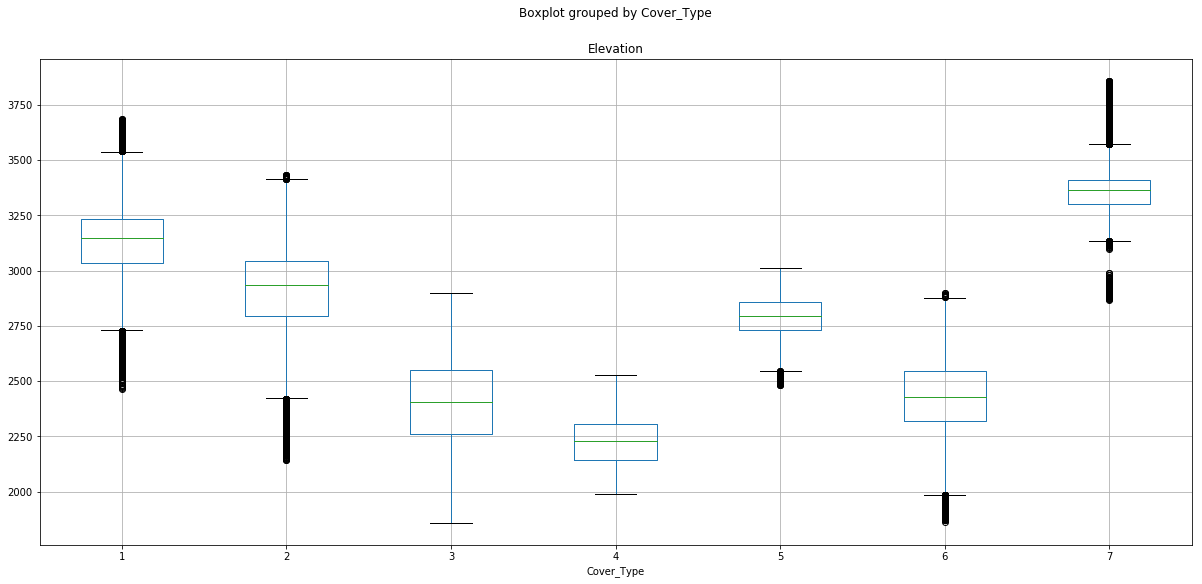

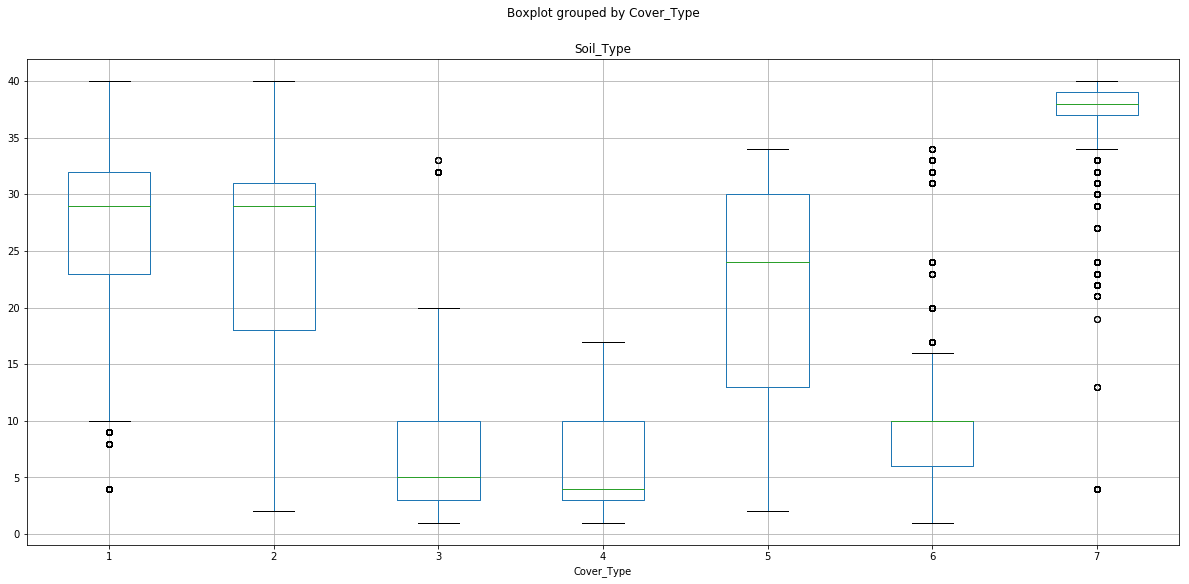

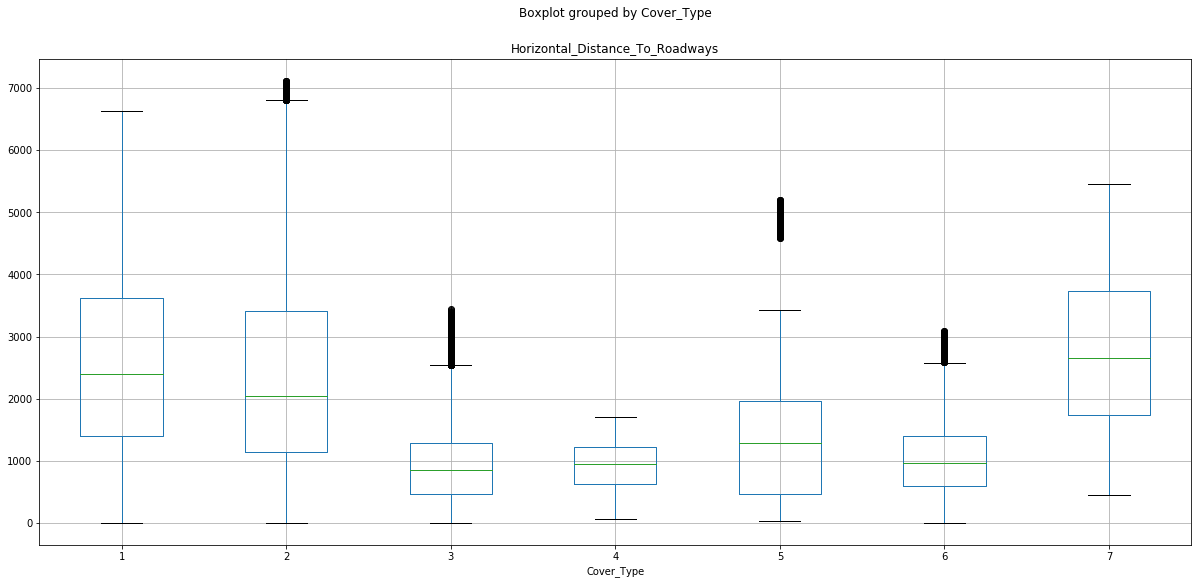

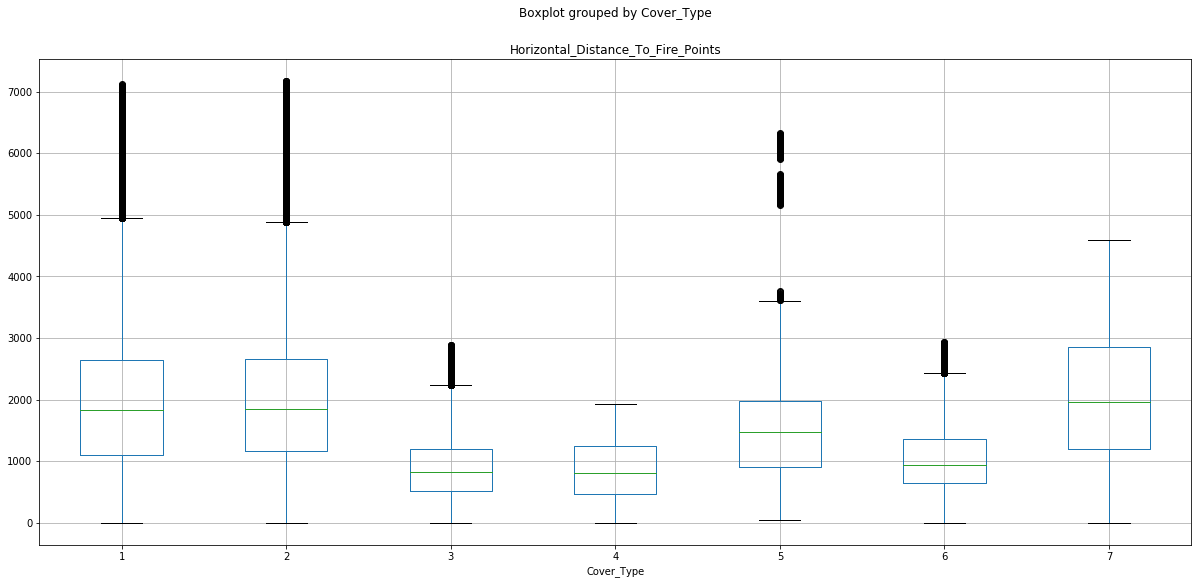

In [36]:
for attribut in ['Elevation','Soil_Type','Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']:
    df_covtype.boxplot(column=attribut,by='Cover_Type')
    plt.show()

Ici on voit que les données sur l'ombre au solstice ne varient pas beaucoup selon les types de forêts. Sans doute que moyenner ces trois valeurs peut être utile. Voyons déjà quels liens elles ont entre elles :

In [37]:
data,layout = covtype.scatter(df_covtype,['Hillshade_Noon','Hillshade_9am','Hillshade_3pm'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='hillshade-scatter')

On peut voir que les données sont corrélées. On peut potentiellement réduire le nombre d'attributs et/ou les transformer pour exhiber ces corrélations.

### Modifications des données

D'abord, on utilisera plutôt le cosinus de la pente des arbres $\verb!Slope!$, plutôt que la pente. On aura des valeurs comprises entre -1 et 1, ce qui facilite les calculs. De plus, l'ombrage, c'est-à-dire les attributs $\verb!Hillshade_9am!$, $\verb!Hillshade_Noon!$ et $\verb!Hillshade_3pm!$ s'exprime d'une manière (linéaire) ou d'une autre par le cosinus de la pente des arbres, ce qui peut aussi faciliter les calculs.

In [38]:
cos_slope = np.cos(df_covtype.Slope.values * np.pi/180)
df_covtype['cos_Slope'] = cos_slope

On ajoute 4 attributs, la moyenne des attributs $\verb!Hillshade_9am!$, $\verb!Hillshade_Noon!$ et $\verb!Hillshade_3pm!$, ainsi que les produits de ces trois derniers.

In [39]:
hillshade_mean = df_covtype[['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']].mean(axis=1)
prod_hillshade_9amNoon = df_covtype.Hillshade_9am.values * df_covtype.Hillshade_Noon.values/255
prod_hillshade_9am3pm = df_covtype.Hillshade_9am.values * df_covtype.Hillshade_3pm.values/255
prod_hillshade_Noon3pm = df_covtype.Hillshade_3pm.values * df_covtype.Hillshade_Noon.values/255

df_covtype['Hillshade_mean'] = hillshade_mean
df_covtype['Corr_Hillshade_9amNoon'] = prod_hillshade_9amNoon
df_covtype['Corr_Hillshade_9am3pm'] = prod_hillshade_9am3pm
df_covtype['Corr_Hillshade_Noon3pm'] = prod_hillshade_Noon3pm

In [40]:
data,layout=covtype.scatter(df_covtype,['Corr_Hillshade_9amNoon','Corr_Hillshade_9am3pm','Corr_Hillshade_Noon3pm'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='corr_hillshade-scatter')

Inutilisable.... Vaut mieux garder juste la moyenne je pense

In [41]:
data,layout=covtype.scatter(df_covtype,['Elevation','cos_Slope','Hillshade_mean'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='slope-scatter')

On introduit un nouvel attribut qui en remplacera une paire :
$$ \verb!Distance_To_Hydrology! = \sqrt{\verb!Vertical_Distance_To_Hydrology!^2 + \verb!Horizontal_Distance_To_Hydrology!^2}$$

In [42]:
def dist(x,y):
    return np.sqrt(np.array(x)**2 + np.array(y)**2)

df_covtype['Distance_To_Hydrology'] = dist(df_covtype.Vertical_Distance_To_Hydrology.values,
                                           df_covtype.Horizontal_Distance_To_Hydrology.values)

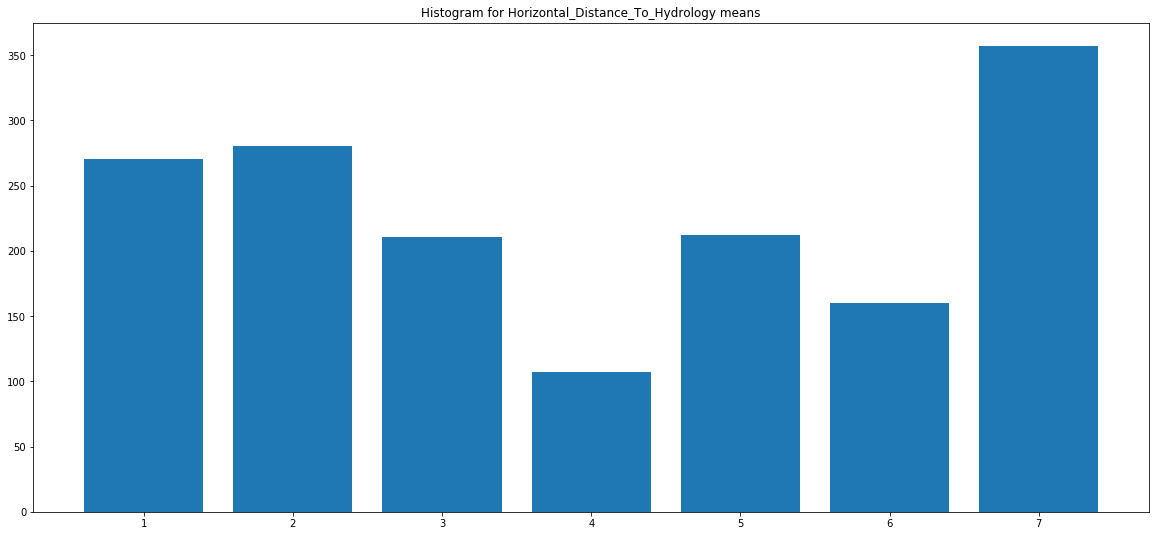

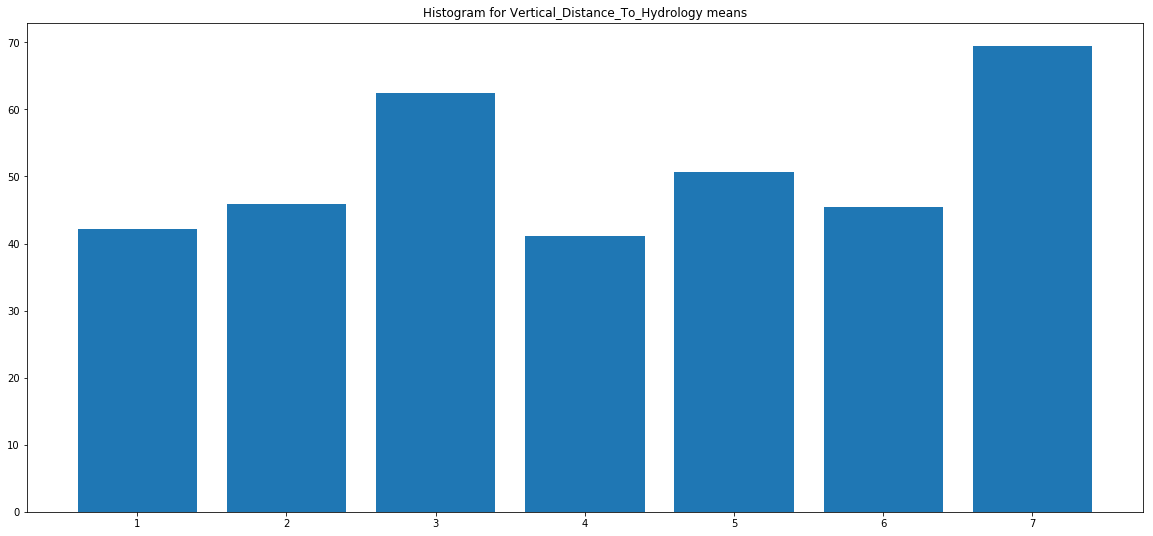

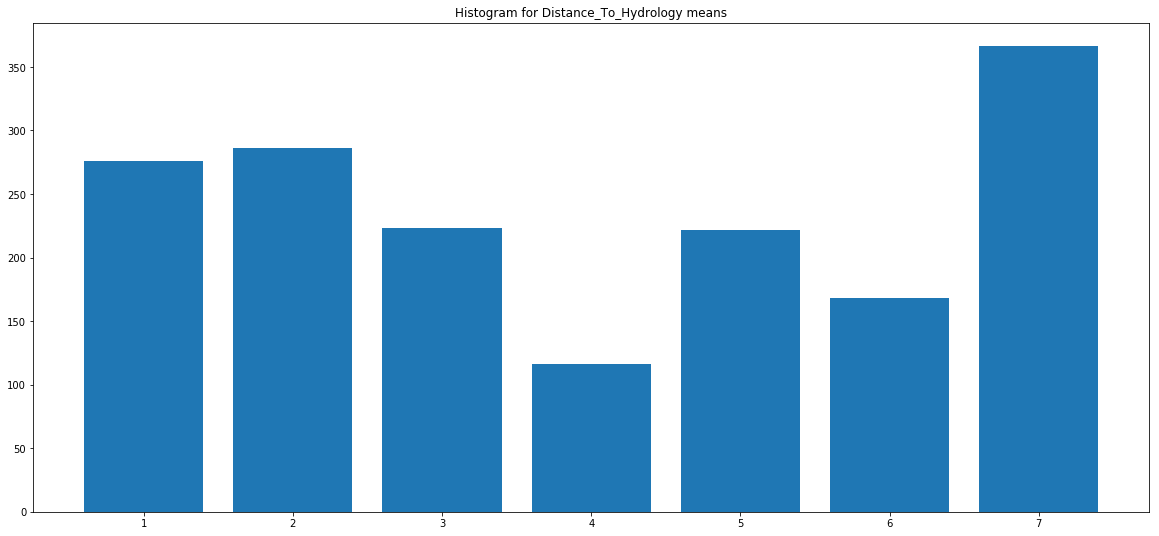

In [43]:
for attribut in ['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Distance_To_Hydrology']:
    plt.bar(covtypes,df_covtype.groupby('Cover_Type')[attribut].mean())
    plt.title('Histogram for ' + attribut + ' means')
    plt.show()

## Données de train/validation/test

In [ ]:
# On sépare les labels et les données qualitatives des features,puis on supprime les colonnes inutiles
data0 = df_covtype.drop(['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
                         'Slope','Cover_Type','Wilderness_Area','Soil_Type'],axis=1).values
target = df_covtype.Cover_Type.values

N,d = data0.shape
N,w = np.array(wilderness).shape
N,s = np.array(soil).shape
data = np.zeros((N,d+w+s))

# Normalisation
for i in range(d):
    x = data0[:,i]
    data0[:,i] = (x-np.mean(x))/sum(x)

# On remet les données qualitative de sorte à pouvoir les exploiter
for n in range(N):
    deleted_data = np.concatenate([wilderness[n],soil[n]])
    data[n] = np.concatenate([data0[n],deleted_data])

data.shape,np.linalg.matrix_rank(data)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Ensemble de train et ensemble de test
(x_train,x_test,y_train,y_test) = train_test_split(data,target,random_state=0,test_size=.1)

# Ensemble de validation 
(x_train,x_valid,y_train,y_valid) = train_test_split(x_train,y_train,test_size=.11)

# Résumé
print("x_train shape:", x_train.shape, 
      "y_train shape:", y_train.shape)
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')

## Test de différents modèles

Nous étudierons les modèles suivant :
    - SVG
    - KNN
    - ANN
    - RandomForest
    - ExtremeRandomForest

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import time

### Regression logistique

On cherche d'abord du côté de la regression logistique multinomiale. Comme elle est sensible aux trop grandes variances, on décide d'utiliser un paramètre de régularisation grâce à la pénalité *elastic net*. La loi a posteriori sachant que les données sont $(\textbf{x},\textbf{y}) = (\textbf{x}^{(i)},\textbf{y}^{(i)})_{i=1}^N$ est une loi multinomiale *(softmax)* 
$$\Pr (\widehat{y}=k \vert \textbf{w};\textbf{x}) = \frac{\exp(w_{0,k} + \textbf{w}_k .\textbf{x})}{\sum_{j=1}^7 \exp(w_0 + \textbf{w}_j . \textbf{x})} $$ 

et sa fonction de coùt est donc donnée par la log-vraisemblance 

$$\ell(\textbf{w};\textbf{x},\textbf{y}) = \left[\frac{1}{N} \sum_{i=1}^{N} \left( \sum_{j=1}^7 y^{(i)}_j (w_{0,j} + \textbf{w}_j.\textbf{x}^{(i)}) - \log \sum_{j=1}^7 e^{w_{0,j} + \textbf{w}_j . \textbf{x}^{(i)}} \right) \right] + \lambda \left[ \frac{1 - \alpha}{2} \sum_{j=1}^7 \vert \vert \textbf{w}_j \vert \vert^2 + \alpha \sum_{j=1}^7 \vert \vert \textbf{w}_j \vert \vert \right]$$

où $N$ est le nombre d'observations. Le second terme de l'équation représente le terme de régularisation *elastic net*.

La pénalité elastic net $\alpha$ varie de 0 à 1. Quand $\alpha=0$, on a une regularisation L2, quand $\alpha=1$, on a une régularisation L1 ("lasso").

In [ ]:
Lambda = np.linspace(1e-6,1e-3,100)

SDG = [SGDClassifier(loss='log',penalty='elasticnet',random_state=0,alpha=a,l1_ratio=.3) for a in Lambda]
SDG_score = []

for clf in SDG:
    # Apprentissage
    logging.info("Training for lambda = " + str(clf.alpha))
    start = time.time()
    clf.fit(x_train,y_train)
    end = time.time()
    logging.info('Training Time : ' + str(end - start))

    # Test
    logging.info("Testing") 
    score,test_time = summarize(clf,x_valid,y_valid)
    SDG_score.append(score)
    logging.info('Testing Time : ' + str(test_time))

In [ ]:
plt.scatter(Lambda,SDG_score)
plt.plot(Lambda,SDG_score)
plt.title('Accuracy by lambda')
plt.show()

### k-plus proches voisins

C'est un algorithme très lent, car il calcule la distance entre chaque point et les autres points, à chaque itération. En effet, la règle de calcul pour les k-plus proches voisins est $$\widehat{y} = argmax_{c} \sum_{x^{(i)} \in V_k} w_i \delta_{y^{(i)},c} $$ où $V_k$ est le voisinage des $k$ points les plus proches de nos données. Nous nous contenterons de l'entrainer sur un ensemble de 100 000 données.

In [ ]:
K = range(1,20)

kNN = [KNeighborsClassifier(k) for k in K]

In [ ]:
kNN_score = []

for clf in kNN:
    
    # Apprentissage
    logging.info("Training for k = " + str(clf.n_neighbors))
    start = time.time()
    clf.fit(x_train[:100000],y_train[:100000])
    end = time.time()
    logging.info('Training Time : ' + str(end - start))
    
    # Test
    logging.info("Testing")
    start = time.time()
    score = clf.score(x_valid[:10000],y_valid[:10000])
    end = time.time()
    kNN_score.append(score)
    logging.info('Testing Time : ' + str(end-start))

In [ ]:
plt.scatter(K,kNN_score)
plt.plot(K,kNN_score)
plt.title('Accuracy by k')
plt.show()

### Random Forest

#### Variations du paramètre n_estimators

#### Variations du paramètre max_depth

On voit qu'on atteint un seuil à $max\_depth = 50$. On tente de tracer toutes les courbes sur une même figure.

In [ ]:
RFC_scores=[]
Depth = range(10,51,10)
N_estimators = range(1,16)

RFC_lib = [[RandomForestClassifier(max_depth=depth,n_estimators=n,
                             verbose=1,n_jobs=5, random_state=0,
                             max_features=data.shape[1]) for n in N_estimators] for depth in Depth]

for RFC in RFC_lib:
    score=[]

    for clf in RFC:
        # Apprentissage
        logging.info("Training for n_estimators = " + str(clf.n_estimators) + " and max_depth = " + str(clf.max_depth))
        start = time.time()
        clf.fit(x_train,y_train)
        end = time.time()
        logging.info('Training Time : ' + str(end - start))

        # scoring
        logging.info("Testing")
        start = time.time()
        score0 = clf.score(x_valid,y_valid)
        end = time.time()
        score.append(score0)
        logging.info('Testing Time : ' + str(end-start) + '\nAccuracy : ' + str(score0))
        
    RFC_scores.append(score)

In [ ]:
for depth,scores in zip(Depth,RFC_scores):
    plt.scatter(N_estimators,scores,label='max_depth = '+str(depth))
    plt.plot(N_estimators,scores)
plt.title('Accuracy by n_estimators and max_depth')
plt.legend()
plt.show()

### Multi-layer perceptron

#### With sklearn

In [ ]:
Alpha = [.01]

# Collection de classifier en fonction du parametre n_estimators
MLP=[MLPClassifier(hidden_layer_sizes=[112,56,28,14,7],alpha=a,activation='tanh',verbose=1,random_state=0) for a in Alpha]
                       
MLP_score=[]

for clf in MLP:

    # Apprentissage
    logging.info("Training for alpha = " + str(clf.alpha))
    start = time.time()
    clf.fit(x_train,y_train)
    end = time.time()
    logging.info('Training Time : ' + str(end - start))

    # Test
    logging.info("Testing")
    score,test_time = summarize(clf,x_valid,y_valid)
    MLP_score.append(score)
    logging.info('Testing Time : ' + str(test_time) + '\n Accuracy : ' + str(score))

In [ ]:
mlp=MLP[0]
mlp.loss_

### With keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(14, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(max(labels), activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train[:50000])
encoded_Y = encoder.transform(y_train[:50000])

In [ ]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
results = cross_val_score(estimator, x_train[:50000], encoded_Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))